## ch2 데이터 전처리

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2022.09.09 </div>
<div style="text-align: right\"> Last update: 2022.09.09</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import FinanceDataReader as fdr

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [3]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [4]:
def plot_single_ts(df, x, y, title = '', xlabel = 'Date', ylabel = 'Value', color = 'tab:red'):
    plt.figure(figsize = (14, 5))
    plt.plot(x, y, color = color)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [5]:
def plot_multi_ts(df, x, y, title = '', xlabel = 'Date', ylabel = 'Value', color = 'tab:red'):
    fig, ax = plt.subplots(figsize = (15, 5))
    df.set_index(x).plot(ax=ax, color=color)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [6]:
def load_dexcom_data(path, sampling_time='5min'):
    df = pd.read_csv(path)
    df = df[df['타임스탬프(YYYY-MM-DDThh:mm:ss)'].notnull()]
    df = df.iloc[:,[1, 7]]
    df.columns = ['timestamp', 'glucose']
    df = df.reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].dt.round(sampling_time)
    df = df.dropna()
    idx = pd.date_range(df['timestamp'].min(), df['timestamp'].max(), freq=sampling_time)
    df = df.set_index('timestamp').reindex(idx, fill_value=np.nan).reset_index().rename(columns = {'index': 'timestamp'})
    
    return df

### 1. 결측치(Missing values) 처리

임의로 결측치를 만든 데이터 셋

In [10]:
path = 'dexcom_sample.csv'
cgm = load_dexcom_data(path)

path_missing = 'dexcom_missing.csv'
cgm_missing = load_dexcom_data(path_missing)

일부만 차트 그려보기

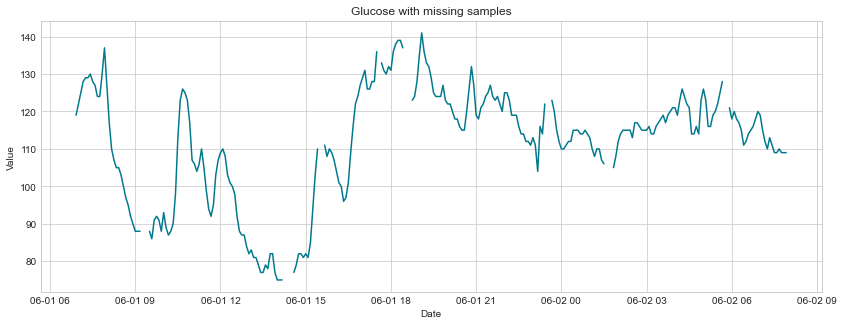

In [11]:
plot_single_ts(cgm_missing, x = cgm_missing.loc[:300, 'timestamp'], y = cgm_missing.loc[:300, 'glucose'], color=colors[0],
       title= 'Glucose with missing samples')

결측치 처리 방법에 따른 차이

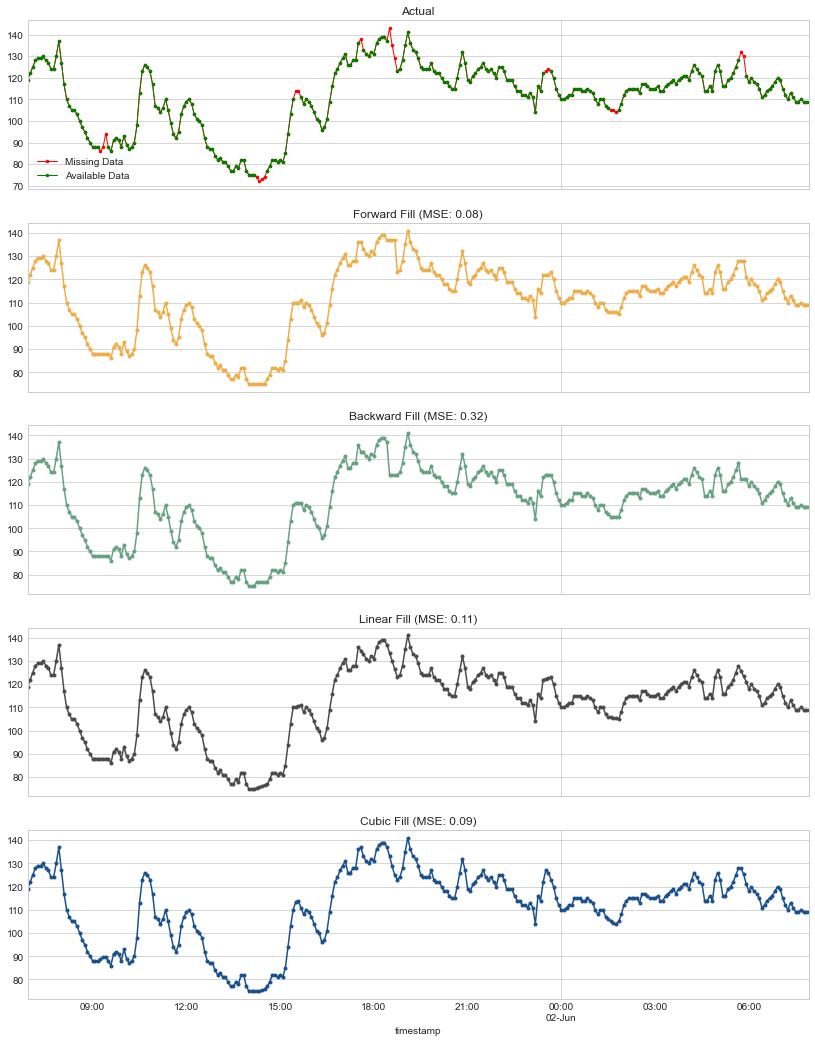

In [12]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(14, 18))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
cgm.loc[:300, ['timestamp', 'glucose']].set_index('timestamp').plot(title='Actual', ax=axes[0], 
                                                                    label='Actual', color='red', style=".-", linewidth = 1, markersize = 5)
cgm_missing.loc[:300, ['timestamp', 'glucose']].set_index('timestamp').plot(title='Actual', ax=axes[0],
                                                                            label='Actual', color='green', style=".-", linewidth = 1, 
                                                                           markersize= 5)
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
cgm_ffill = cgm_missing.ffill()
error = np.round(mean_squared_error(cgm['glucose'], cgm_ffill['glucose']), 2)
cgm_ffill.loc[:300, ['timestamp', 'glucose']].set_index('timestamp').plot(title='Forward Fill (MSE: ' + str(error) +")",
                                                                          color = colors[2],
                                                                       ax=axes[1], label='Forward Fill', style=".-")
axes[1].get_legend().remove()   

# ## 3. Backward Fill -------------------------
cgm_bfill = cgm_missing.bfill()
error = np.round(mean_squared_error(cgm['glucose'], cgm_bfill['glucose']), 2)
cgm_bfill.loc[:300, ['timestamp', 'glucose']].set_index('timestamp').plot(title='Backward Fill (MSE: ' + str(error) +")", 
                                                                          color=colors[3],
                                                                          ax=axes[2], label='Forward Fill', style=".-")
axes[2].get_legend().remove()  

# ## 4. Linear Interpolation ------------------
cgm_missing['rownum'] = np.arange(cgm_missing.shape[0])
cgm_missing_dropna = cgm_missing.dropna(subset = ['glucose'])
f = interp1d(cgm_missing_dropna['rownum'], cgm_missing_dropna['glucose'])
cgm_missing['linear_fill'] = f(cgm_missing['rownum'])
error = np.round(mean_squared_error(cgm['glucose'], cgm_missing['linear_fill']), 2)
cgm_missing.loc[:300, ['timestamp', 'linear_fill']].set_index('timestamp').plot(title="Linear Fill (MSE: " + str(error) +")", 
                                                                                color = colors[4],
                                                                ax=axes[3], label='Cubic Fill', style=".-")
axes[3].get_legend().remove()  

# ## 5. Cubic Interpolation --------------------
f2 = interp1d(cgm_missing_dropna['rownum'], cgm_missing_dropna['glucose'], kind='cubic')
cgm_missing['cubic_fill'] = f2(cgm_missing['rownum'])
error = np.round(mean_squared_error(cgm['glucose'], cgm_missing['cubic_fill']), 2)
cgm_missing.loc[:300, ['timestamp', 'cubic_fill']].set_index('timestamp').plot(title="Cubic Fill (MSE: " + str(error) +")", 
                                                                                ax=axes[4], label='Cubic Fill', color = colors[5],
                                                                               style=".-")
axes[4].get_legend().remove()  

### 2. Smoothing
노이즈 제거 : $S_{t}$ = $aX_{t}$ + $(1-a)S_{t-1}$

In [13]:
cgm['glucose_ewm'] = cgm.set_index('timestamp').ewm(alpha=0.8).mean()['glucose'].values

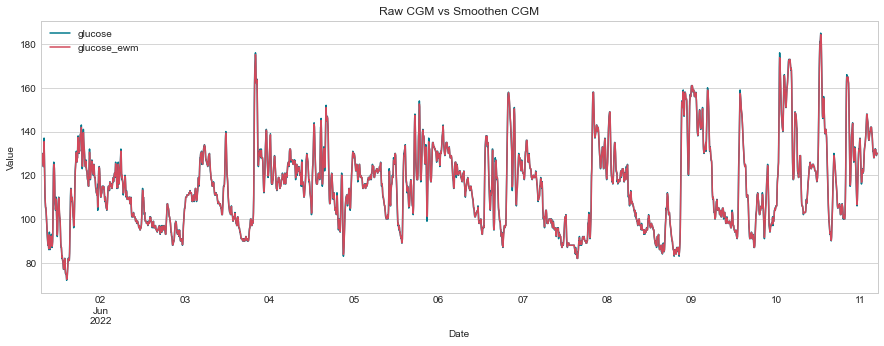

In [14]:
plot_multi_ts(cgm, x = 'timestamp', y = cgm.iloc[:, 1:], color=colors,
       title= 'Raw CGM vs Smoothen CGM')

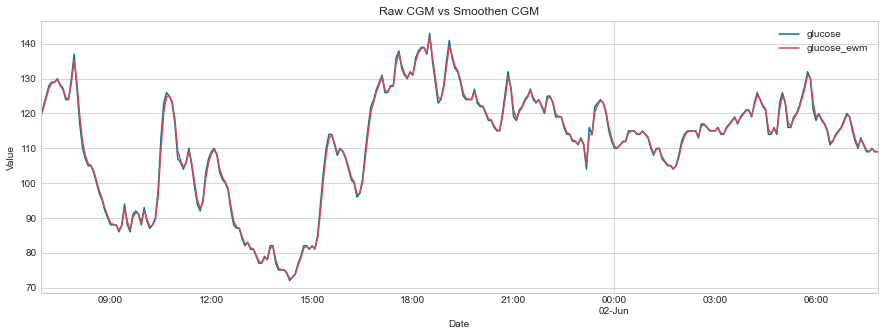

In [16]:
plot_multi_ts(cgm.iloc[:300], x = 'timestamp', y = cgm.iloc[:, 1:], color=colors,
       title= 'Raw CGM vs Smoothen CGM')

### 3. Resampling

In [20]:
cgm_10min = cgm.set_index('timestamp').resample('10min')['glucose'].mean().reset_index()

In [21]:
cgm = cgm.merge(cgm_10min, on='timestamp', how = 'left')
cgm.columns = ['timestamp', 'glucose', 'glucose_ewm', 'glucose_10min']

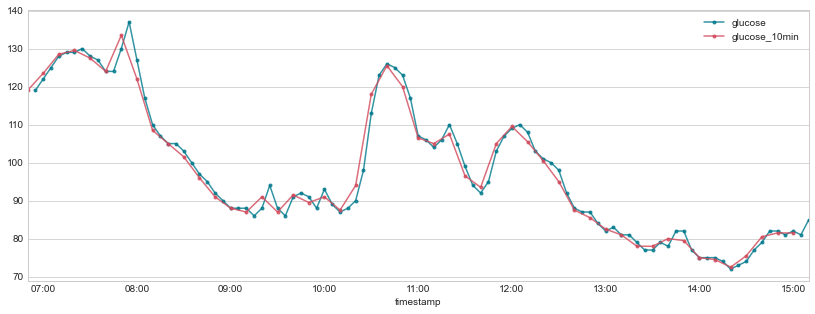

In [24]:
fig, ax = plt.subplots(figsize = (12, 5))
cgm.iloc[:100].set_index('timestamp')['glucose'].plot(figsize = (14, 5), color = colors[0], alpha = 0.8, ax = ax, style = '.-')
cgm.set_index('timestamp').resample('10min')['glucose'].mean().iloc[:50].plot(figsize = (14, 5), color = colors[1], style = '.-', 
                                                                               alpha = 0.8, ax = ax)
plt.legend(['glucose', 'glucose_10min'])

In [23]:
cgm.set_index('timestamp').head()

,glucose,glucose_ewm,glucose_10min
timestamp,,,
2022-06-01 06:55:00,119.0,119.000000,NaN
2022-06-01 07:00:00,122.0,121.500000,123.5
2022-06-01 07:05:00,125.0,124.322581,NaN
2022-06-01 07:10:00,128.0,127.269231,128.5
2022-06-01 07:15:00,129.0,128.654289,NaN


### 4. Transformation

- differencing : 트렌드 제거  
- log transformation : 분산 일정하게

In [25]:
air = pd.read_csv('https://raw.githubusercontent.com/sguys99/datasets/master/airline_passengers.csv')
air['Month'] = pd.to_datetime(air['Month'])

In [26]:
air['diff'] = air['Thousands of Passengers'].diff()
air['log'] = np.log(air['Thousands of Passengers'])
air['log_diff'] = np.log(air['Thousands of Passengers']).diff()
air['log_diff_diff'] = air['log_diff'].diff()

In [27]:
air.head()

,Month,Thousands of Passengers,diff,log,log_diff,log_diff_diff
0,1949-01-01,112,NaN,4.718499,NaN,NaN
1,1949-02-01,118,6.0,4.770685,0.052186,NaN
2,1949-03-01,132,14.0,4.882802,0.112117,0.059932
3,1949-04-01,129,-3.0,4.859812,-0.022990,-0.135107
4,1949-05-01,121,-8.0,4.795791,-0.064022,-0.041032


<AxesSubplot:>

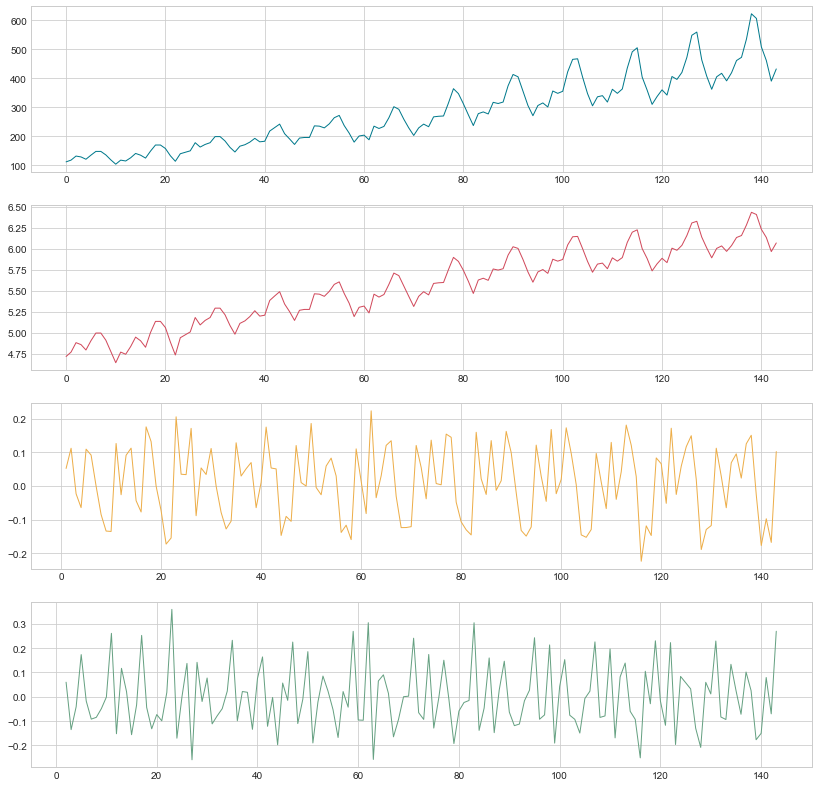

In [28]:
fig, axes = plt.subplots(4, 1, figsize = (14, 14))
air['Thousands of Passengers'].plot(color= colors[0], linewidth = 1, ax = axes[0])

air['log'].plot(color= colors[1], linewidth = 1, ax = axes[1])

air['log_diff'].plot(color= colors[2], linewidth = 1, ax = axes[2])

air['log_diff_diff'].plot(color= colors[3], linewidth = 1, ax = axes[3])

In [29]:
# raw data
ADF_result = adfuller(air['Thousands of Passengers'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641


In [30]:
# log transformation
ADF_result = adfuller(air['log'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.7170170891069607
p-value: 0.42236677477039125


In [31]:
# differencing
ADF_result = adfuller(air['log_diff'].backfill())

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.6671577665673776
p-value: 0.07989585732372884


In [33]:
ADF_result = adfuller(air['log_diff_diff'].dropna())

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.196629132182231
p-value: 7.419304549376505e-13


CGM 데이터에 differencing 적용하기

In [34]:
cgm.head()

,timestamp,glucose,glucose_ewm,glucose_10min
0,2022-06-01 06:55:00,119.0,119.000000,NaN
1,2022-06-01 07:00:00,122.0,121.500000,123.5
2,2022-06-01 07:05:00,125.0,124.322581,NaN
3,2022-06-01 07:10:00,128.0,127.269231,128.5
4,2022-06-01 07:15:00,129.0,128.654289,NaN


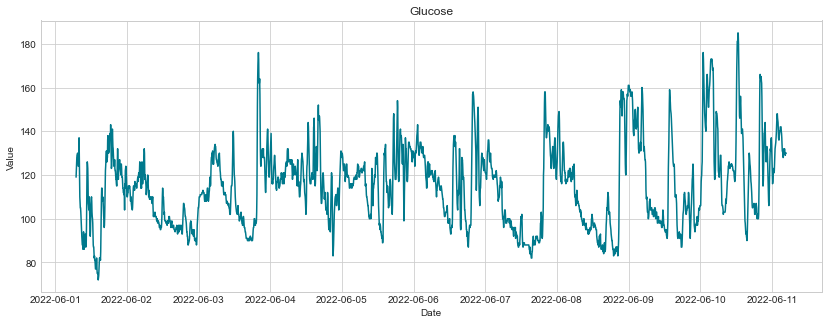

In [36]:
plot_single_ts(cgm, x = cgm['timestamp'], y = cgm['glucose'], color=colors[0],
       title= 'Glucose')

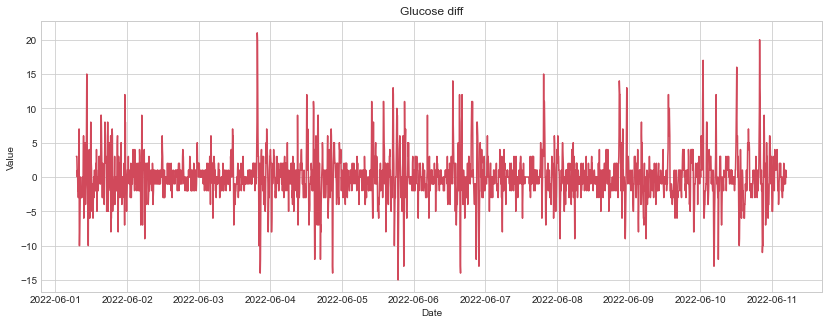

In [38]:
plot_single_ts(cgm, x = cgm['timestamp'], y = cgm['glucose'].diff(), color=colors[1],
       title= 'Glucose diff')

In [39]:
cgm['glucose_diff'] = cgm['glucose'].diff()

In [40]:
cgm.head()

,timestamp,glucose,glucose_ewm,glucose_10min,glucose_diff
0,2022-06-01 06:55:00,119.0,119.000000,NaN,NaN
1,2022-06-01 07:00:00,122.0,121.500000,123.5,3.0
2,2022-06-01 07:05:00,125.0,124.322581,NaN,3.0
3,2022-06-01 07:10:00,128.0,127.269231,128.5,3.0
4,2022-06-01 07:15:00,129.0,128.654289,NaN,1.0


In [41]:
# raw data
ADF_result = adfuller(cgm['glucose'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.470310232403398
p-value: 1.3723898142673895e-08


In [42]:
# differencing
ADF_result = adfuller(cgm['glucose_diff'].dropna())

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -19.812965367118167
p-value: 0.0
